# Ni and Fe microspectrocopy data from BNL

1. **Fe_xanes** (from HXN) is a model system sample used for optimizing nano-XANES workflow. We know the "true value" chemical state map. The aggregate is composed of 
        a. LiFe(II)PO4 (LFP)

        b. Pyrite (Pyr)

        c. StainlessSteelNP (SS) and

        d. Hematite_NP (Hem).

      *Please note that this is unpublished data from a submitted MS*


2. **Ni_xanes** is NMC?

In [27]:
from ipywidgets import IntSlider, widgets, interactive, fixed

import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import gridspec
import matplotlib.patches as mpatches

import selector
from selector import energy_point_selector
from importlib import reload

import utils
utils = reload(utils)
from utils import *

np.random.seed(42)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in data

(101, 320, 320)
(73, 155, 160)


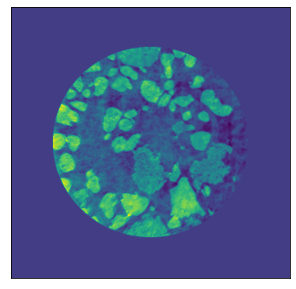

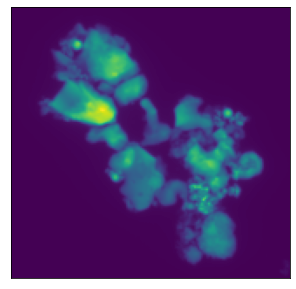

In [3]:
Ni_xanes = parse_tiff('Data/TXM_XANES/Ni_xanes.tiff')
Ni_energy = np.loadtxt('Data/TXM_XANES/Ni_eng_list.txt')

Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')
Fe_energy = np.loadtxt('Data/HXN_XANES/energy_list_corr.txt')

def plot_img(data):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])

print(Ni_xanes.shape)
print(Fe_xanes.shape)

plot_img(np.average(Ni_xanes, axis=0))
plot_img(np.average(Fe_xanes, axis=0))

In [4]:
def plot_spectra(i, Data):
    fig, ax = plt.subplots(figsize=(5, 5))    
    data = Data[i]
    ax.imshow(data, extent=[0, 1, 0, 1], aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        

data = Fe_xanes
slider = IntSlider(min=0, max=len(data) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))
interactive(plot_spectra, i=slider, Data=fixed(data))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=72), Output()), _dom…

# Iron References

## Interpolating Fe XANES and Refs onto same energy grid

In [5]:
ref_energy, Refs_dict, Refs_raw = parse_nor('Data/HXN_XANES/FeLibNov2021.nor')
energy = np.linspace(7090, 7196, 54)

interperlator = interp1d(ref_energy, Refs_raw)
Refs = interperlator(energy)

Fe_xanes_tmp = np.zeros((len(energy), Fe_xanes.shape[1], Fe_xanes.shape[2]))
for x in range(Fe_xanes.shape[1]):
    for y in range(Fe_xanes.shape[2]):
        interperlator = interp1d(Fe_energy, Fe_xanes[:, x, y])
        Fe_xanes_tmp[:, x, y] = interperlator(energy)

Fe_xanes = Fe_xanes_tmp
Fe_energy = energy

(12, 196)


# Some visualization

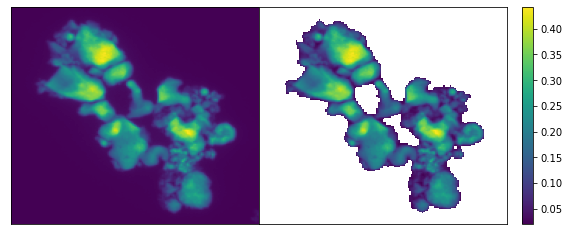

In [6]:
data = Fe_xanes

fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')
ax = fig.add_subplot(spec[1])
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1], aspect='auto')

for ax in fig.get_axes():
    remove_ticks(ax)

plt.colorbar(img)
plt.show()

In [7]:
%matplotlib inline

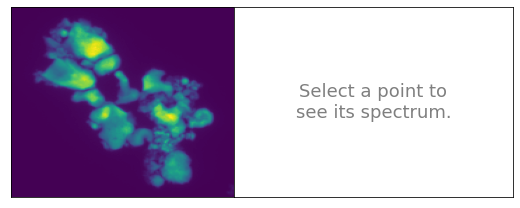

In [8]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto')

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

# Step 1. Filter out background, i.e., space with no sample

In [9]:
data = Fe_xanes
energy = Fe_energy

fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

# Step 2. Normalize experimental spectra

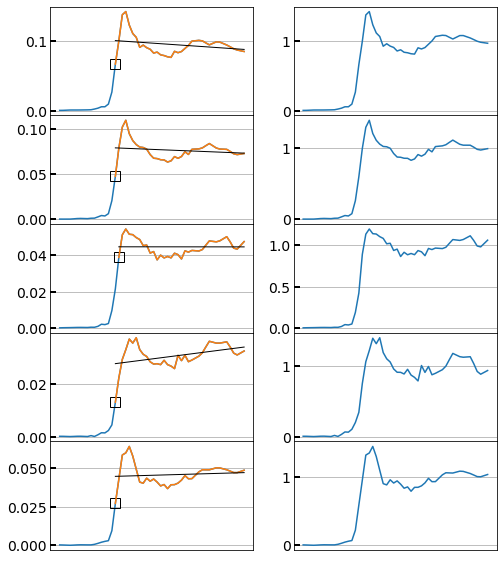

In [10]:
N = 5
fig, axes = plt.subplots(figsize=(8, 2 * N), ncols=2, nrows=N)
plt.subplots_adjust(wspace=0.2, hspace=0)

for i, spectrum in enumerate(filtered_spectra[50:]):
    ax = axes[i, 0]
    whiteline, y_fit, y_norm = normalize_spectrum(energy, spectrum, verbose=True)
    
    ax.plot(energy, spectrum)
    ax.plot(energy[whiteline], spectrum[whiteline],
            's', c='k', markersize=10, fillstyle='none')
    ax.plot(energy[whiteline:], spectrum[whiteline:], '-', c=plt.cm.tab10(1))
    ax.plot(energy[whiteline:], y_fit, 'k-', linewidth=1)
    
    ax = axes[i, 1]
    ax.plot(energy, y_norm)
    
    for ax in axes[i]:
        ax.set_xticks([])
        ax.tick_params(direction='in', width=2, length=6, labelsize=14)
        ax.grid()
    
    if i == N - 1:
        break

In [11]:
normalized_spectra, normalized_spectra_dict = normalize_spectra(energy,
                                                                filtered_spectra,
                                                                filtered_spectra_dict)

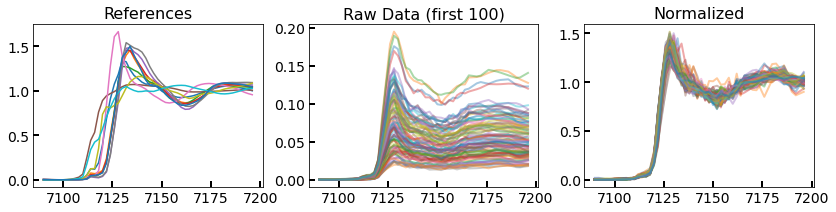

In [12]:
fig, axes = plt.subplots(figsize=(14, 3), ncols=3)
plt.subplots_adjust(wspace=0.2)

for r in Refs:
    axes[0].plot(energy, r)
    
c = 0
for i, spectrum in enumerate(filtered_spectra):
    axes[1].plot(energy, spectrum, linewidth=2, alpha=0.4)
    axes[2].plot(energy, normalized_spectra[i], linewidth=2, alpha=0.4)
    c += 1
    if c > 100:
        break

titles = ['References', 'Raw Data (first 100)', 'Normalized']

for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=16)
    ax.tick_params(direction='in', width=2, length=6, labelsize=14)

# Step 3. Cluster Spectra
# PIPELINE: PCA --> UMAP --> dbscan --> clustering

It takes 9 PCs to explain 95% variance.


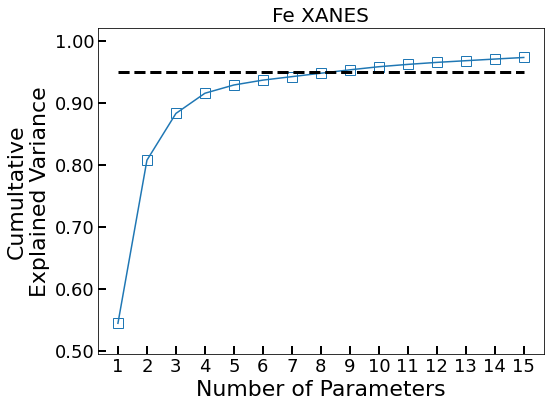

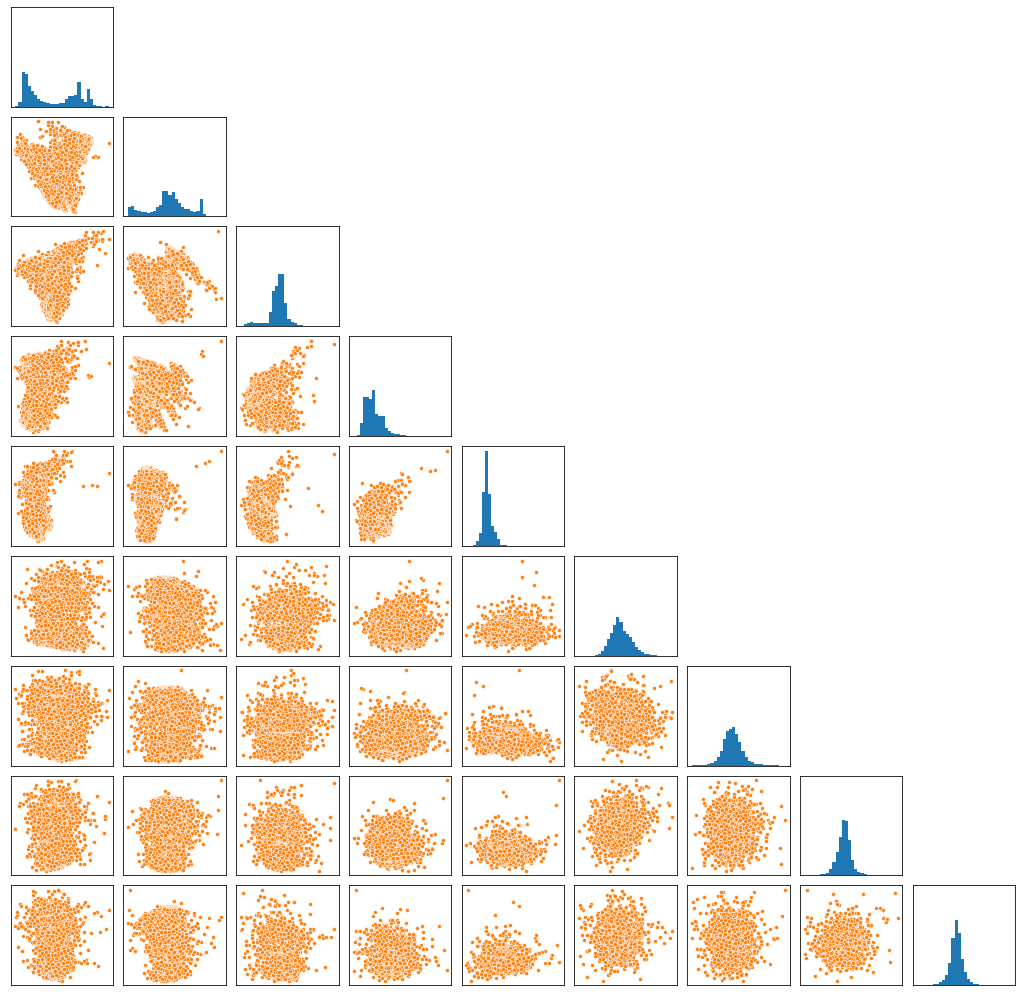

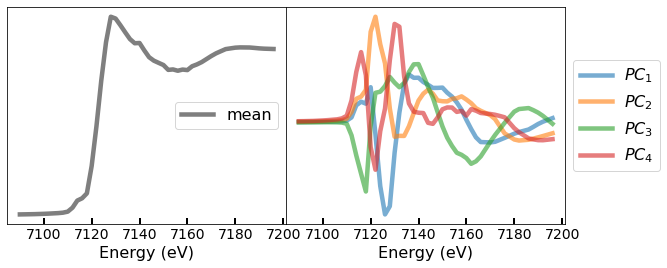

6 -> 6
0 -> 16
1 -> 17
7 -> 13
3 -> 18
2 -> 7
5 -> 12
4 -> 19


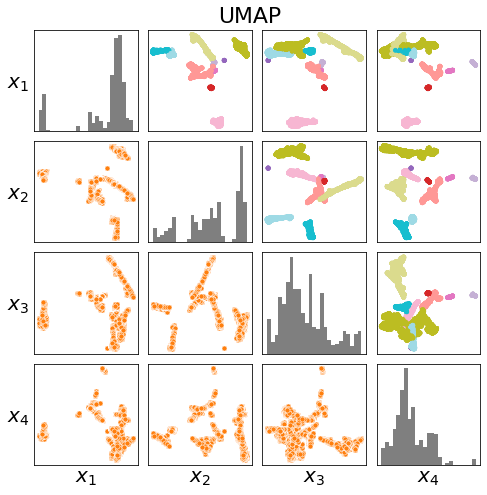

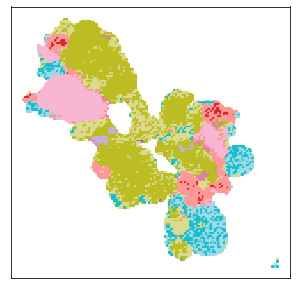

In [19]:
# PCA
n_components = make_scree_plot(normalized_spectra, n=15, c=0, threshold=0.95, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.show()

pca, pca_components = make_PCA_traingle_plot(normalized_spectra, n_components)

show_PCs(energy, pca, n=4)

# UMAP & dbscan
color_labels, codemap, dbscan_clustering = make_UMAP_plot(pca_components, normalized_spectra_dict,
                                                          n_neighbors=4.5, min_dist=0, dimension=4)

# Final clusters
plot_color_code_map(normalized_spectra_dict, color_labels)

# Step 4. LCF

### First find cluster averages

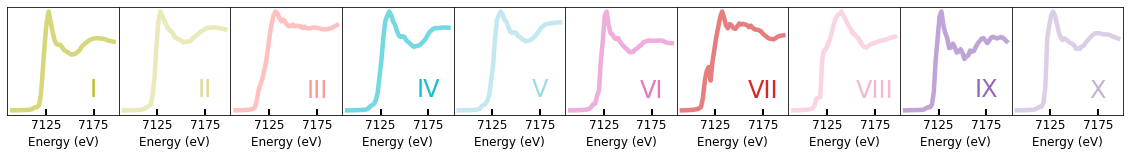

In [22]:
cluster_avgs = get_cluster_avgs(normalized_spectra_dict, color_labels, dbscan_clustering)
plot_cluster_avgs(energy, cluster_avgs, codemap)

## How reliable are Refs fitted onto themselves?

It takes 3 PCs to explain 95% variance.


3

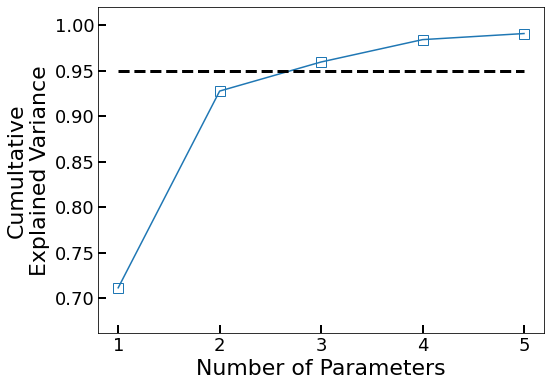

In [23]:
make_scree_plot(Refs, threshold=.95, show_first_PC=False)

In [222]:
subset_size = 5
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = Refs 
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], targets, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scales.append(scale)
    scores.append(score)

[0 7] 3.534014473330836e-06
[1 9] 5.7580522572883045e-06
[2 5] 2.028238124126596e-07
[3 5] 2.497991488563412e-07
[0 4] 1.619169459219158e-07
[5 7] 1.578770530818656e-06
[6 9] 4.707492768725837e-06
[6 7] 1.1623983893398305e-06
[3 8] 7.829746687440049e-06
[2 9] 1.4070691840690987e-05
[ 5 10] 3.257456161881011e-08


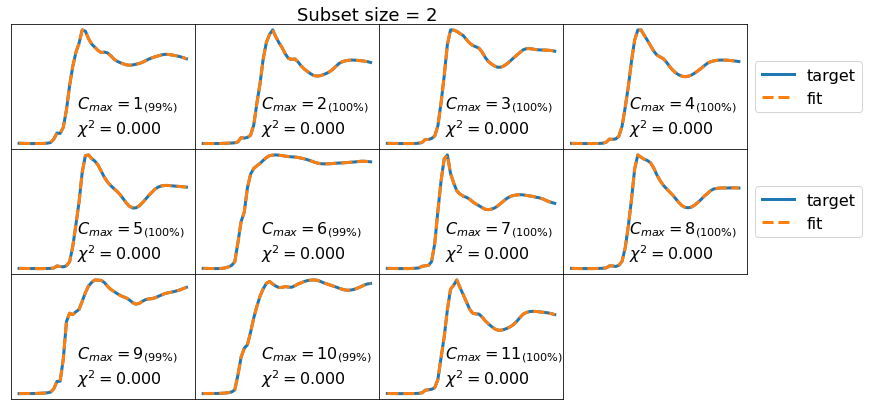

In [223]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                verbose=True, ncols=4, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

## Cluster averages fit to Refs

In [29]:
subset_size = 2
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    scales.append(scale)
    coeffs.append(coeffs_hat)
    scores.append(score)

[ 6 10] 0.1191003504138241
[2 6] 0.09844239833875124
[7 9] 0.035510434489553204
[1 2] 0.08432000265458517
[2 5] 0.14940716605950416
[0 6] 0.06333141871020884
[7 9] 0.199076096121448
[7 8] 0.24368811670022272
[ 6 10] 0.1761980082560268
[5 6] 0.13466078096232748


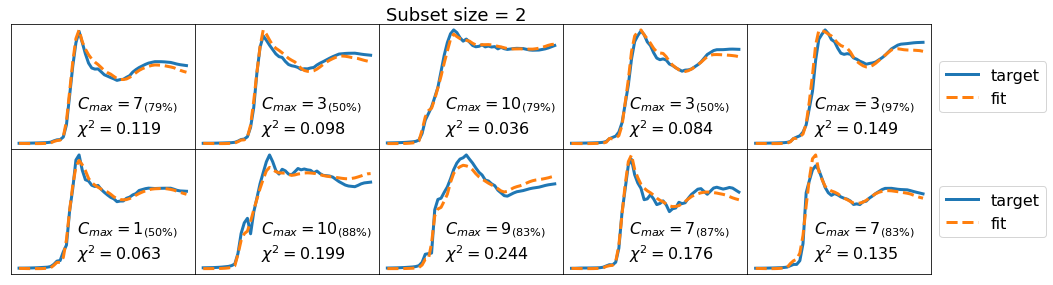

In [30]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                ncols=5, flag_identity=False, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

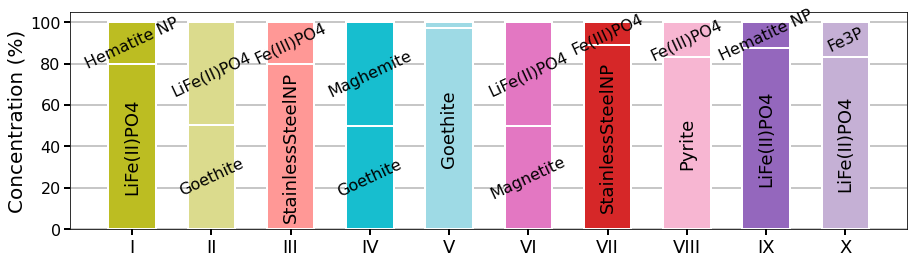

In [32]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.5, 4))
plot_conc_from_subset((fig, ax), np.array(coeffs).reshape(len(coeffs), -1),
                      list(Refs_dict.keys()), subset_indices, codemap)

# PART II. Recursive Feature Elimination

In [232]:
energy_point_selector = reload(selector.energy_point_selector)

In [234]:
best_estimator = 'Random Forest'
best_n = 5
Is = []

reps = 500
for i in range(reps):
    print(i, end='\r')
    kwargs = {'N': 10, 'scale': 0.0, 'dropout': 0.85}
    data, coeffs = generate_linear_combos(Refs, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                      verbose=False, scoring='neg_root_mean_squared_error',
                                      n_estimators=50)
    energy_measurements = energy[rfe.support_]
    indices = [i for i, e in enumerate(energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

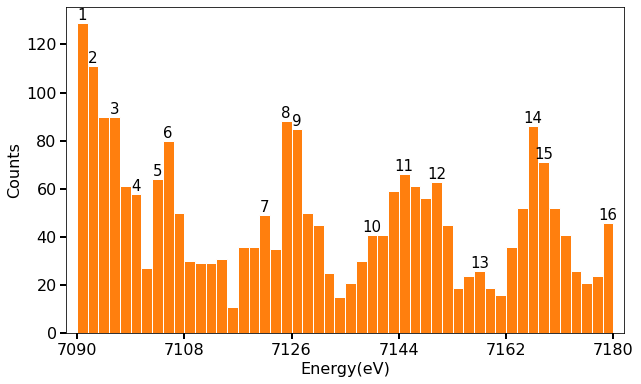

In [271]:
fig, ax = plt.subplots(figsize=(10, 6))
indices = [0, 1, 3, 5, 7, 8, 17, 19, 20, 27, 30, 33, 37, 42, 43, 49]
labels = np.arange(1, len(indices) + 1)
label_map = {idx: label for idx, label in zip(indices, labels)}
histogram_of_importance((fig, ax), Is.reshape(-1), energy, label_map=label_map)
plt.show()

# Back to the pipeline on energy subset
## Step 1. Slice energies

In [ ]:
indices = [0, 1, 3, 5, 7, 8, 17, 19, 20, 27, 30, 33, 37, 42, 43, 49]
X_energies = np.array(energy[indices])
Y_Refs = Refs[:, indices]
data_subset = np.array(normalized_spectra)[:, indices]

## Step 2. Clustering pipeline

In [ ]:
# PCA
n_components_sub = make_scree_plot(data_subset, n=15, c=0, threshold=0.95, show_first_PC=False)
plt.title('Fe XANES subset', fontsize=20)
plt.show()

pca, pca_components = make_PCA_traingle_plot(data_subset, n_components_sub)

show_PCs(energy, pca, n=4)

# UMAP
color_labels_sub = make_UMAP_plot(pca_components, n_neighbors=4.5, min_dist=0, dimension=4)

# Final Clusters
color_code_map(normalized_spectra_dict, color_labels_sub)

## Step 3. LCF

In [ ]:
clusters = {i: [] for i in np.unique(dbscan_clustering.labels_)}

for i, key in enumerate(list(normalized_spectra_dict.keys())):
    spectrum = normalized_spectra_dict[key]
    color = dbscan_clustering.labels_[i]
    clusters[color].append(spectrum)

cluster_avgs = {key: np.average(clusters[key], axis=0) for key in list(clusters.keys())}

In [ ]:
subset_size = 2
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], Refs, subset_size,
                                                     lambda1=0.1, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    scales.append(scale)
    coeffs.append(coeffs_hat)
    scores.append(score)

In [ ]:
plot_recon_grid(energy, targets, subset_indices, subsets, scales, coeffs, Refs_dict,
                ncols=5, flag_identity=False, c=1)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.5, 4))
plot_conc_from_subset((fig, ax), np.array(coeffs).reshape(len(coeffs), -1),
                      list(Refs_dict.keys()), subset_indices, codemap)